# Visualization of Kalman Filter performance

In [78]:
import scipy;
import matplotlib.pyplot as plt;
from bokeh.io import output_notebook
from RootInteractive.Tools.aliTreePlayer import *
from RootInteractive.InteractiveDrawing.bokeh.bokehDrawSA import *
from RootInteractive.Tools.aliTreePlayer import *
from RootInteractive.InteractiveDrawing.bokeh.CDSCompress import *
from RootInteractive.InteractiveDrawing.bokeh.bokehInteractiveParameters import *
#import forestci as fci
from bokeh.io import curdoc
from IPython.display import display, HTML
import seaborn as sns
display(HTML("<style>.container { width:100% !important; }</style>"))

In [79]:
import sys,os; sys.path.insert(1, os.environ[f"fastMCKalman"]+'/fastMCKalman/MC/');  from test_fastSimulation import *

In [80]:
#inputList="/home/federico/Documents/Universita/Federico_2020-2021/Aliwork/fastMCKalman/data/testTPCMirror/fastParticle.list"
inputList=os.environ[f"fastMCKalman"]+"/fastMCKalman/tests/fastParticle.list"
import multiprocessing
nCores=multiprocessing.cpu_count()


In [81]:
%%time 
inputList=os.environ[f"fastMCKalman"]+"/data/testTPCMirror/fastParticle.list"
#inputList=os.environ[f"fastMCKalman"]+"/fastMCKalman/tests/fastParticle.list"
df=loadData(inputList)

CPU times: user 7.38 s, sys: 975 ms, total: 8.36 s
Wall time: 8.74 s
Number of entries	1
0	0	/home/federico/Documents/Universita/Federico_2020-2021/Aliwork/fastMCKalman/data/testTPCMirror/fastParticle.root
Number of entries	1
0	0	/home/federico/Documents/Universita/Federico_2020-2021/Aliwork/fastMCKalman/data/testTPCMirror/fastParticle.root
Number of entries	1
0	0	/home/federico/Documents/Universita/Federico_2020-2021/Aliwork/fastMCKalman/data/testTPCMirror/fastParticle.root
Number of entries	1
0	0	/home/federico/Documents/Universita/Federico_2020-2021/Aliwork/fastMCKalman/data/testTPCMirror/fastParticle.root


In [82]:
nCores

16

## Make BDT Forest Regression

In [83]:
varIn=["fPdgCodeMC","paramFullMC2","paramFullMC3","paramFullMC4","NPointsFullRefit"]
target="pullFullRefit4"
n_estimators=200
n_jobs=nCores//2
nPoints=500000
max_depthBase=12
max_samples=0.10

regressor = RandomForestRegressor(n_estimators =n_estimators,n_jobs=n_jobs,max_depth=max_depthBase,max_samples=max_samples)
#dfFit=df.query("(statusMaskFullRefit&0x2000)>0")
dfFit0=df[((df["statusMaskFullRefit"]&0x2000)>0)].query(f"abs({target})<10")
dfFit1=dfFit0.sample(frac=0.10).sort_index()
#
#
nAll=dfFit1.shape[0]
X_train = dfFit1[varIn].iloc[:nAll//2]
X_test = dfFit1[varIn].iloc[nAll//2:]
Y_train = dfFit1[target].iloc[:nAll//2]
Y_test = dfFit1[target].iloc[nAll//2:]

forest = regressor.fit(X_train, Y_train)


dfFit1[f"{target}Pred0"]=regressor.predict(dfFit1[varIn])
Y_hat_train = dfFit1[f"{target}Pred0"].iloc[:nAll//2]
Y_hat_test = dfFit1[f"{target}Pred0"].iloc[nAll//2:]

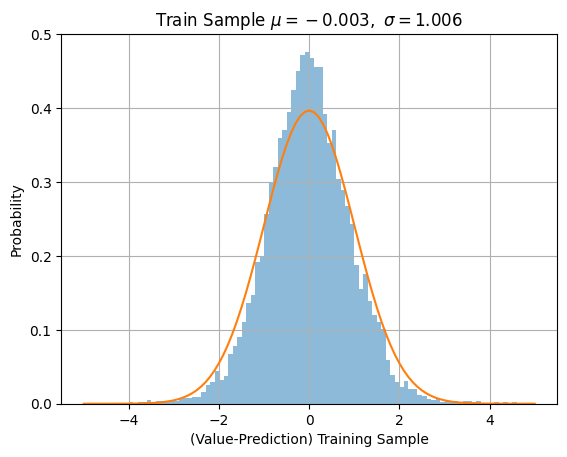

mean = -0.0028765887773398737   sigma = 1.005650859801699


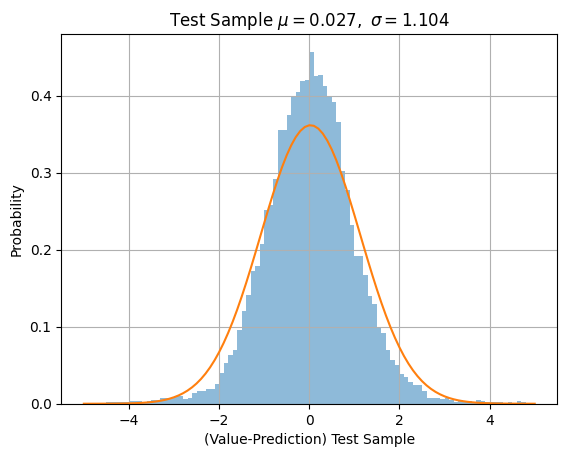

mean = 0.026891442018604543   sigma = 1.1035086001951748


In [84]:
train_diff = Y_hat_train-Y_train
test_diff = Y_hat_test-Y_test

#Plot and fit differences in 
_, bins, _ = plt.hist(train_diff.values, 100, density=1,alpha=0.5,range=[-5, 5])
mu, sigma = scipy.stats.norm.fit(train_diff.values)
best_fit_line = scipy.stats.norm.pdf(bins, mu, sigma)
plt.plot(bins, best_fit_line)
plt.xlabel('(Value-Prediction) Training Sample')
plt.ylabel('Probability')
plt.title(r'$\mathrm{Train \ Sample}\ \mu=%.3f,\ \sigma=%.3f$' %(mu, sigma))
plt.grid(True)
plt.show()
print("mean =",str(mu),"  sigma =",str(sigma))

#Plot 
_, bins, _ = plt.hist(test_diff.values, 100, density=1,alpha=0.5,range=[-5, 5])
mu, sigma = scipy.stats.norm.fit(test_diff.values)
best_fit_line = scipy.stats.norm.pdf(bins, mu, sigma)
plt.plot(bins, best_fit_line)
plt.xlabel('(Value-Prediction) Test Sample')
plt.ylabel('Probability')
plt.title(r'$\mathrm{Test \ Sample}\ \mu=%.3f,\ \sigma=%.3f$' %(mu, sigma))
plt.grid(True)
plt.show()
print("mean =",str(mu),"  sigma =",str(sigma))

## Create pull Interactive HTML

In [85]:
variables=list(np.sort(df.columns))
variables+=["funCustom0","funCustom1","funCustom1"]

# here we can define derivd variables -  to define some invariances eg abs(XX_Mean/XXXMedain)<
aliasArray=[
#    ("","dNprimdx*padLength"),     # ionization over pad
    ("Unit","1+paramFullMC4*0"),
    ("Refit_OK","(0x1*(abs(pullFullRefit0)<10)) |(0x2*(abs(pullFullRefit1)<10)) | (0x4*(abs(pullFullRefit2)<10)) | (0x8*(abs(pullFullRefit3)<10)) |  (0x10*(abs(pullFullRefit4)<10))"),
    ("In_OK","(0x1*(abs(pullFullIn0)<10)) |(0x2*(abs(pullFullIn1)<10)) | (0x4*(abs(pullFullIn2)<10)) | (0x8*(abs(pullFullIn3)<10)) |  (0x10*(abs(pullFullIn4)<10))"),
    ("Out_OK","(0x1*(abs(pullFullOut0)<10)) |(0x2*(abs(pullFullOut1)<10)) | (0x4*(abs(pullFullOut2)<10)) | (0x8*(abs(pullFullOut3)<10)) |  (0x10*(abs(pullFullOut4)<10))"),
]
# defining custom java script function to query  (used later in varaible list)
aliasArray+=[
    {
        "name": "funCustom0",
        "variables": [i for i in variables if  "ustom" not in i ],
        "func":"funCustomForm0",
    },
    {
        "name": "funCustom1",
        "variables": [i for i in variables if   "ustom" not in i],
        "func":"funCustomForm1",
    },
    {
        "name": "funCustom2",
        "variables": [i for i in variables if   "ustom" not in i],
        "func":"funcCustomForm2",
    },
]


variables+=["Unit"]



parameterArray = [
    {"name": "varX", "value":"paramFullMC4", "options":variables},
    {"name": "varY", "value":"pullFullRefit4", "options":variables},
    {"name": "varYNorm", "value":"Unit", "options":variables},
    {"name": "varZ", "value":"paramFullMC4", "options":variables},
    {"name": "varZNorm", "value":"Unit", "options":variables},
    {"name": "nbinsX", "value":30, "range":[10, 200]},
    {"name": "nbinsY", "value":30, "range":[10, 200]},
    {"name": "nbinsZ", "value":5, "range":[1,10]},
    #{"name": "sigmaNRel", "value":3.35, "range":[1,5]},
    #
    {"name": "exponentX", "value":1, "range":[-5, 5]},
    {'name': "xAxisTransform", "value":None, "options":[None, "sqrt", "lambda x: log(1+x)","lambda x: 1/sqrt(x)", "lambda x: x**exponentX","lambda x,y: x/y" ]},
    {'name': "yAxisTransform", "value":None, "options":[None, "sqrt", "lambda x: log(1+x)","lambda x: 1/sqrt(x)", "lambda x: x**exponentX","lambda x,y: y/x" ]},
    {'name': "zAxisTransform", "value":None, "options":[None, "sqrt", "lambda x: log(1+x)","lambda x: 1/sqrt(x)", "lambda x: x**exponentX" ]},
    # custom selection
    {'name': 'funCustomForm0', "value":"return 1"},
    {'name': 'funCustomForm1', "value":"return 1"},
    {'name': 'funCustomForm2', "value":"return 1"},
    # cut variables
    {"name": "minEntries", "value":50, "range":[5, 200]},
    {"name": "sigmaRFCut0", "value":1, "range":[0, 20]},
    {"name": "sigmaRFCutL", "value":1, "range":[0, 20]},
]

parameterArray.extend(figureParameters["legend"]['parameterArray'])   
parameterArray.extend(figureParameters["markers"]['parameterArray'])    

widgetParams=[
    #fastMC Kalman controls
    ['range', ['paramFullMC2'], {"name": "paramFullMC2"}],
    ['range', ['paramFullMC3'], {"name": "paramFullMC3"}],
    ['spinnerRange', ['paramFullMC4'], {"name": "paramFullMC4"}],
    ['spinnerRange', ['NPointsFullRefit'], {"name": "NPointsFullRefit"}],
    ['multiSelect', ['fPdgCodeMC'], {"name": "fPdgCodeMC"}],
    ['multiSelect', ['statusMaskFullRefit'],{"name": "statusMaskFullRefit"}],
    #
    ['multiSelectBitmask',["Refit_OK"],{"name":"Refit_OK","mapping": {"P0": 1, "P1": 2, "P2": 4,"P3":8, "P4":16}, "how":"all", "title": "Refit OK"}],
    ['multiSelectBitmask',["In_OK"],{"name":"In_OK","mapping": {"P0": 1, "P1": 2, "P2": 4,"P3":8, "P4":16}, "how":"all", "title": "In OK"}],
    ['multiSelectBitmask',["Out_OK"],{"name":"Out_OK","mapping": {"P0": 1, "P1": 2, "P2": 4,"P3":8, "P4":16}, "how":"all", "title": "Out OK"}],
    #
    ['spinnerRange', ['pullFullRefit0'], {"name": "pullFullRefit0"}],
    ['spinnerRange', ['pullFullRefit1'], {"name": "pullFullRefit1"}],
    ['spinnerRange', ['pullFullRefit2'], {"name": "pullFullRefit2"}],
    ['spinnerRange', ['pullFullRefit3'], {"name": "pullFullRefit3"}],
    ['spinnerRange', ['pullFullRefit4'], {"name": "pullFullRefit4"}],
    #
    # template entries
    ['textQuery', {"name": "customSelect0","value":"return 1"}],
    ['textQuery', {"name": "customSelect1","value":"return 1"}],
    ['textQuery', {"name": "customSelect2","value":"return 1"}],
    #
    ['text', ['funCustomForm0'], {"name": "funCustomForm0"}],
    ['text', ['funCustomForm1'], {"name": "funCustomForm1"}],
    ['text', ['funCustomForm2'], {"name": "funCustomForm2"}],
    #
    ['slider', ["minEntries"],{"name": "minEntries"}],
    ['slider', ["sigmaRFCut0"],{"name": "sigmaRFCut0"}],
    ['slider', ["sigmaRFCutL"],{"name": "sigmaRFCutL"}],
    
    #['textQuery', {"name": "customSelect2"}],
#    ['spinnerRange',["logq2NPrimRatio"],{"name":"logq2NPrimRatio","range": [-2, 4]}],
#    ['spinnerRange',["lognTot2NPrimRatio"],{"name":"lognTot2NPrimRatio"}],
    #
    ['select', ['varX'], {"name": "varX"}],
    ['select', ['varY'], {"name": "varY"}],
    ['select', ['varYNorm'], {"name": "varYNorm"}],
    ['select', ['varZ'], {"name": "varZ"}],
    ['select', ['varZNorm'], {"name": "varZNorm"}],
    ['slider', ['nbinsY'], {"name": "nbinsY"}],
    ['slider', ['nbinsX'], {"name": "nbinsX"}],
    ['slider', ['nbinsZ'], {"name": "nbinsZ"}],
    #
    ['spinner', ['exponentX'],{"name": "exponentX"}],
    #['spinner', ['sigmaNRel'],{"name": "sigmaNRel"}],
    ['select', ['yAxisTransform'], {"name": "yAxisTransform"}],
    ['select', ['xAxisTransform'], {"name": "xAxisTransform"}],
    ['select', ['zAxisTransform'], {"name": "zAxisTransform"}],
]                         

widgetParams.extend(figureParameters["legend"]["widgets"])
widgetParams.extend(figureParameters["markers"]["widgets"])

widgetLayoutDesc={
    "Select":[["paramFullMC2","paramFullMC3","paramFullMC4"],["NPointsFullRefit","fPdgCodeMC","statusMaskFullRefit"]],
    "SelectQA":[["pullFullRefit0","pullFullRefit1","pullFullRefit2","pullFullRefit3","pullFullRefit4"],
               ["Refit_OK","In_OK","Out_OK"]],
     #"Select":[["sector","A_Side","partition","isEdgePad","IDC0_MeanMedian"],["QMax_Clusters_OK","QMax_Digits_OK","SAC0_OK","IDC0_OK","IDC0_MeanOK"],["padrow","lx","gx","gy"],],
    "Custom":[["customSelect0","customSelect1","customSelect2"],["funCustomForm0","funCustomForm1","funCustomForm2"],["minEntries","sigmaRFCut0","sigmaRFCutL"]],
    "Histograms":[["nbinsX","nbinsY", "nbinsZ", "varX","varY","varYNorm","varZ","varZNorm"], {'sizing_mode': 'scale_width'}],
    "Transform":[["exponentX","xAxisTransform", "yAxisTransform","zAxisTransform"],{'sizing_mode': 'scale_width'}],
    "Legend": figureParameters['legend']['widgetLayout'],
    "Markers":["markerSize"]
}

figureGlobalOption={}
figureGlobalOption=figureParameters["legend"]["figureOptions"]
figureGlobalOption["size"]="markerSize"
figureGlobalOption["x_transform"]="xAxisTransform"
figureGlobalOption["y_transform"]="yAxisTransform"
figureGlobalOption["z_transform"]="zAxisTransform"

In [86]:
histoArray=[    
    {
        "name": "histoXYData",
        "variables": ["varX","varY"],
        "nbins":["nbinsX","nbinsY"], "axis":[1],"quantiles": [0.35,0.5],"unbinned_projections":True,
    },
    {
        "name": "histoXYNormData",
        "variables": ["varX","varY/varYNorm"],
        "nbins":["nbinsX","nbinsY"], "axis":[1],"quantiles": [0.35,0.5],"unbinned_projections":True,
    },
    {
        "name": "histoXYZData",
        "variables": ["varX","varY","varZ"],
        "nbins":["nbinsX","nbinsY","nbinsZ"], "axis":[1,2],"quantiles": [0.35,0.5],"unbinned_projections":True,
    },
    {
        "name": "histoXYNormZData",
        "variables": ["varX","varY/varYNorm","varZ"],
        "nbins":["nbinsX","nbinsY","nbinsZ"], "axis":[1,2],"quantiles": [0.35,0.5],"unbinned_projections":True,
    },
    {
        "name": "histoXYZNormData",
        "variables": ["varX","varY","varZ/varZNorm"],
        "nbins":["nbinsX","nbinsY","nbinsZ"], "axis":[1,2],"quantiles": [0.35,0.5],"unbinned_projections":True,
    },
]

In [87]:
figureArray=[
    #
    [[("bin_bottom_0", "bin_top_0")], [("bin_bottom_1", "bin_top_1")], {"colorZvar": "bin_count", "source":"histoXYData"}],
    [["bin_center_1"], ["bin_count"], { "source":"histoXYData", "colorZvar": "bin_center_0"}],
    [["bin_center_0"], ["mean","quantile_1",], { "source":"histoXYData_1","errY":"std/sqrt(entries)"}],
    [["bin_center_0"], ["std"], { "source":"histoXYData_1","errY":"std/sqrt(entries)"}],
    #
    [[("bin_bottom_0", "bin_top_0")], [("bin_bottom_1", "bin_top_1")], {"colorZvar": "bin_count", "source":"histoXYNormData"}],
    [["bin_center_1"], ["bin_count"], { "source":"histoXYNormData", "colorZvar": "bin_center_0"}],
    [["bin_center_0"], ["mean","quantile_1",], { "source":"histoXYNormData_1","errY":"std/sqrt(entries)"}],
    [["bin_center_0"], ["std"], { "source":"histoXYNormData_1","errY":"std/sqrt(entries)"}],
    #
    [["bin_center_0"], ["mean"], { "source":"histoXYZData_1","colorZvar":"bin_center_2","errY":"std/sqrt(entries)"}],
    [["bin_center_0"], ["quantile_0"], { "source":"histoXYZData_1","colorZvar":"bin_center_2","errY":"2*std/sqrt(entries)"}],
    [["bin_center_0"], ["quantile_1"], { "source":"histoXYZData_1","colorZvar":"bin_center_2","errY":"3*std/sqrt(entries)"}],
    [["bin_center_0"], ["std"], { "source":"histoXYZData_1","colorZvar":"bin_center_2","errY":"std/sqrt(entries)"}],
    #
    [["bin_center_0"], ["mean"], { "source":"histoXYNormZData_1","colorZvar":"bin_center_2","errY":"std/sqrt(entries)","yAxisTitle":"{varY}/{varYNorm}"}],
    [["bin_center_0"], ["quantile_0"], { "source":"histoXYNormZData_1","colorZvar":"bin_center_2","errY":"2*std/sqrt(entries)","yAxisTitle":"{varY}/{varYNorm}"}],
    [["bin_center_0"], ["quantile_1"], { "source":"histoXYNormZData_1","colorZvar":"bin_center_2","errY":"3*std/sqrt(entries)","yAxisTitle":"{varY}/{varYNorm}"}],
    [["bin_center_0"], ["std"], { "source":"histoXYNormZData_1","colorZvar":"bin_center_2","errY":"std/sqrt(entries)","yAxisTitle":"{varY}/{varYNorm}"}],
    # global XYZ profile - median
    [[("bin_bottom_0", "bin_top_0")], [("bin_bottom_1", "bin_top_1")], {"colorZvar": "quantile_1", "source":"histoXYZData_2"}],
    [[("bin_bottom_0", "bin_top_0")], [("bin_bottom_1", "bin_top_1")], {"colorZvar": "quantile_1", "source":"histoXYZNormData_2"}],
    # global XYZ profile - mean
    [[("bin_bottom_0", "bin_top_0")], [("bin_bottom_1", "bin_top_1")], {"colorZvar": "mean", "source":"histoXYZData_2"}],
    [[("bin_bottom_0", "bin_top_0")], [("bin_bottom_1", "bin_top_1")], {"colorZvar": "mean", "source":"histoXYZNormData_2"}],  
    #
    figureGlobalOption
]
figureLayoutDesc={
    "histoXY":[[0,1],[2,3],{"plot_height":200}],
    "histoXYNorm":[[4,5],[6,7],{"plot_height":200}],
    "histoXYZ":[[8,9],[10,11],{"plot_height":200}],
    "histoXYNormZ":[[12,13],[14,15],{"plot_height":200}],
    "histoXYNormZMedian":[[16,17],{"plot_height":400}],
    "histoXYNormZMean":[[18,19],{"plot_height":400}],
}

In [88]:
%%time
arrayCompressionRelative10=[(".*",[("relative",10), ("code",0), ("zip",0), ("base64",0)])]
output_file("fastMCKAlmanPulls_Summary.html") 
arrayCompression=arrayCompressionRelative10
dfSample=df.query("abs(paramFullMC4)<200").sample(frac=0.2).sort_index()
fig=bokehDrawSA.fromArray(dfSample, None, figureArray, widgetParams, layout=figureLayoutDesc, sizing_mode='scale_width', nPointRender=50000, widgetLayout=widgetLayoutDesc, 
                          parameterArray=parameterArray, histogramArray=histoArray, rescaleColorMapper=True,aliasArray=aliasArray,arrayCompression=arrayCompressionRelative10)

/home/federico/Documents/Universita/Federico_2020-2021/Aliwork/RootInteractive/RootInteractive/InteractiveDrawing/bokeh/bokehTools.py:1451: FutureWarning: Specifying `na_sentinel=None` is deprecated, specify `use_na_sentinel=False` instead.
  codes, optionsPlot = pd.factorize(dfCategorical, sort=True, na_sentinel=None)


compressCDSPipe
Compress 1 paramFullOut1 .* [('relative', 10), ('code', 0), ('zip', 0), ('base64', 0)]
Compress factor 362024 2916489 0.12413007558060393 1 paramFullOut1
Compress 2 gzMC .* [('relative', 10), ('code', 0), ('zip', 0), ('base64', 0)]
Compress factor 364572 2916480 0.12500411454904542 2 gzMC
Compress 3 paramFullMC1 .* [('relative', 10), ('code', 0), ('zip', 0), ('base64', 0)]
Compress factor 364572 2916488 0.12500377165961252 3 paramFullMC1
Compress 4 paramFullOut4 .* [('relative', 10), ('code', 0), ('zip', 0), ('base64', 0)]
Compress factor 348196 2916489 0.1193887581952135 4 paramFullOut4
Compress 5 paramFullIn1 .* [('relative', 10), ('code', 0), ('zip', 0), ('base64', 0)]
Compress factor 366324 2916488 0.12560449417244302 5 paramFullIn1
Compress 6 ptMC .* [('relative', 10), ('code', 0), ('zip', 0), ('base64', 0)]
Compress factor 37276 2916480 0.01278116085143735 6 ptMC
Compress 7 paramFullOut2 .* [('relative', 10), ('code', 0), ('zip', 0), ('base64', 0)]
Compress factor

# backup

In [89]:
variables

['NPointsFullIn',
 'NPointsFullMC',
 'NPointsFullOut',
 'NPointsFullRefit',
 'fPdgCodeMC',
 'gxIn',
 'gxMC',
 'gyIn',
 'gyMC',
 'gzMC',
 'paramFullIn0',
 'paramFullIn1',
 'paramFullIn2',
 'paramFullIn3',
 'paramFullIn4',
 'paramFullMC0',
 'paramFullMC1',
 'paramFullMC2',
 'paramFullMC3',
 'paramFullMC4',
 'paramFullOut0',
 'paramFullOut1',
 'paramFullOut2',
 'paramFullOut3',
 'paramFullOut4',
 'paramFullRefit0',
 'paramFullRefit1',
 'paramFullRefit2',
 'paramFullRefit3',
 'paramFullRefit4',
 'ptMC',
 'pullFullIn0',
 'pullFullIn1',
 'pullFullIn2',
 'pullFullIn3',
 'pullFullIn4',
 'pullFullOut0',
 'pullFullOut1',
 'pullFullOut2',
 'pullFullOut3',
 'pullFullOut4',
 'pullFullRefit0',
 'pullFullRefit1',
 'pullFullRefit2',
 'pullFullRefit3',
 'pullFullRefit4',
 'statusMaskFullIn',
 'statusMaskFullMC',
 'statusMaskFullOut',
 'statusMaskFullRefit',
 'tglMC',
 'funCustom0',
 'funCustom1',
 'funCustom1',
 'Unit']